In [35]:
import time
from selenium import webdriver
from bs4 import BeautifulSoup
from selenium.webdriver.chrome.service import Service
import xlsxwriter
from typing import List 

In [36]:
# URLs to scrape
urls: List[str] = ['https://www.youtube.com/@chess/videos']

In [37]:
# Initialize variables
times: int = 0
row: int = 0
t: List[str] = []
v: List[str] = []
d: List[str] = []

service = Service(executable_path=r"C:\Program Files (x86)\Google\chromedriver-win64\chromedriver.exe")
options = webdriver.ChromeOptions()
driver = webdriver.Chrome(service=service, options=options)

# Loop through each URL
for url in urls:
    driver.get(f'{url}/videos?view=0&sort=p&flow=grid')
    times: int = 0
    while times < 5:
        time.sleep(1)
        driver.execute_script("window.scrollTo(0, document.documentElement.scrollHeight);")
        times += 1
    content: bytes = driver.page_source.encode('utf-8').strip()
    soup = BeautifulSoup(content, 'html.parser')

# Extract video titles
title_elements = soup.findAll('yt-formatted-string', id='video-title')
for title in title_elements:
    t.append(title.text.strip()) 

# Extract views
view_elements = soup.findAll('span', class_='inline-metadata-item style-scope ytd-video-meta-block')
for view in view_elements:
    if 'просмотров' in view.text:
        v.append(view.text.strip().replace("\u00a0тыс.", "K").replace("\u00a0млн", "M"))

# Extract duration
duration = soup.findAll( 
    'span', class_='style-scope ytd-thumbnail-overlay-time-status-renderer') 
d: List[str] = [] 
for i in duration: 
    d.append(i.text)

driver.quit()


In [38]:
# Creating an Excel workbook and worksheet
workbook = xlsxwriter.Workbook('file.xlsx')
worksheet = workbook.add_worksheet()

# Writing headers
worksheet.write(0, 0, "Title")
worksheet.write(0, 1, "Views")
worksheet.write(0, 2, "Duration")

# Writing data to the worksheet
row = 1
for title, view, duration in zip(t, v, d):
    worksheet.write(row, 0, title)
    worksheet.write(row, 1, view)
    worksheet.write(row, 2, duration)
    row += 1

workbook.close()

In [39]:
#Data preprocessing
import pandas as pd

data: pd.DataFrame = pd.read_excel('file.xlsx')
data.head()

,Title,Views,Duration
0,HIKARU IS THE BULLET KING!!,19K просмотров,\n 27:03\n
1,Hikaru Weighs In On Hans vs. Magnus!,89K просмотров,\n 27:03\n
2,Magnus On Hans: I'll probably win without too ...,88K просмотров,\n 12:25\n
3,Hans Niemann | FULL INTERVIEW,196K просмотров,\n 12:25\n
4,ALIREZA SETS UP THE LAST TRAP FOR FABI,11K просмотров,\n 11:47\n


In [40]:
data['Views'] = data['Views'].str.replace(" просмотров","")
new: List[float] = []

for i in data['Views']:
    i = i.replace(',', '.')

    if i.endswith('K'):
        i = i.replace('K','')
        new.append(float(i) * 1000)
    elif i.endswith('M'):
        i = i.replace('M', '')
        new.append(float(i)*1000000)
    else:
        new.append(float(i))

data['Views'] = new

In [41]:
#Duration column cleaning 
data['Duration'] = data['Duration'].str.replace("\n","") 
  
new2: List[str] = [] 
  
for i in data['Duration']: 
    if(i=='SHORTS' or len(i.split(':'))==1): 
        new2.append(i) 
    elif(len(i.split(':'))==2): 
        i = i.split(':') 
        tim: int = int(i[0])*60 + int(i[1]) 
        new2.append(tim) 
    elif(len(i.split(':'))==3): 
        i = i.split(':') 
        tim: int = int(i[0])*3600 + int(i[1])*60 + int(i[2]) 
        new2.append(tim) 
          
data['Duration'] = new2

In [42]:

#Duration column categorization 
for i in data['Duration'].index: 
    val: str = data['Duration'].iloc[i] 
    if(val=='  SHORTS'): 
        continue
    elif(val in range(0,900)): 
        data.loc[i,'Duration'] = 'Mini-Videos'
    elif(val in range(901,3600)): 
        data.loc[i,'Duration'] = 'Long-Videos'
    else: 
        data.loc[i,'Duration'] = 'Very-Long-Videos'

C:\Users\user\AppData\Local\Temp\ipykernel_4728\2882938310.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Long-Videos' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[i,'Duration'] = 'Long-Videos'


In [43]:
data.head()

,Title,Views,Duration
0,HIKARU IS THE BULLET KING!!,19000.0,Long-Videos
1,Hikaru Weighs In On Hans vs. Magnus!,89000.0,Long-Videos
2,Magnus On Hans: I'll probably win without too ...,88000.0,Mini-Videos
3,Hans Niemann | FULL INTERVIEW,196000.0,Mini-Videos
4,ALIREZA SETS UP THE LAST TRAP FOR FABI,11000.0,Mini-Videos


In [44]:
#Text Preprocessing
import re
from tqdm import tqdm
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [45]:
def preprocess_text(text_data: List[str]) -> List[str]:
    preprocessed_text: List[str] = []

    for sentence in tqdm(text_data):
        sentence = re.sub(r'[^\w\s]', '', sentence)
        preprocessed_text.append(' '.join(token.lower() 
                                          for token in str(sentence).split()
                                          if token not in stopwords.words('english')))
        
    return preprocessed_text

preprocessed_review: List[str] = preprocess_text(data['Title'].values)
data['Title'] = preprocessed_review

100%|██████████| 150/150 [00:00<00:00, 1023.09it/s]


In [46]:
#Data Visualization
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

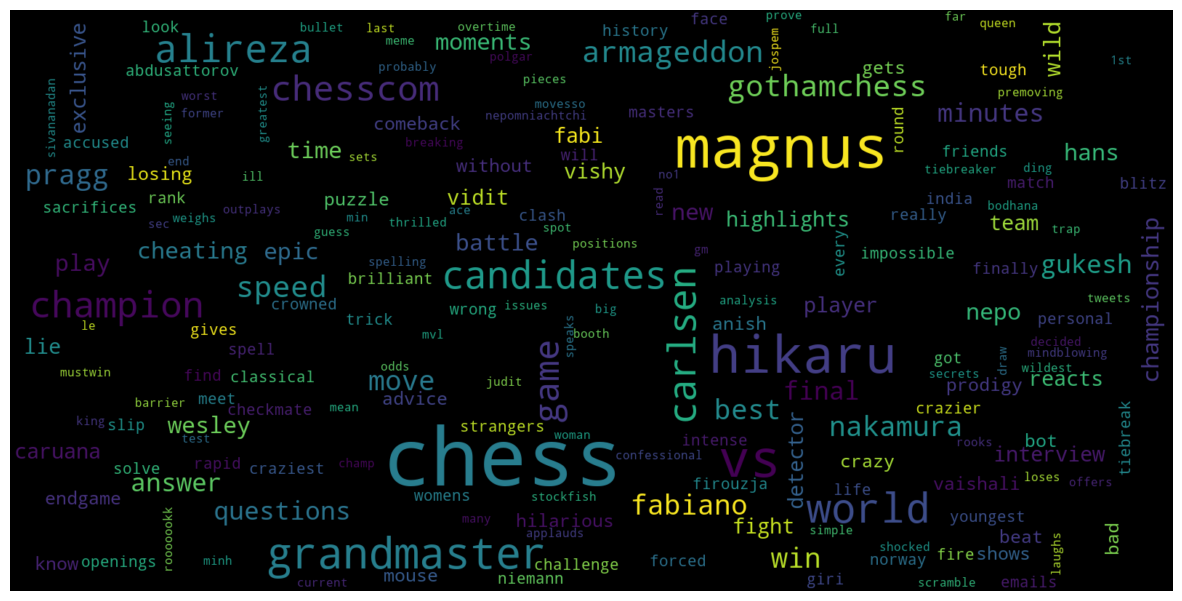

In [47]:
consolidated: str = ' '.join(word for word in data['Title'].astype(str))
wordCloud = WordCloud(width=1600, height=800, random_state=21, max_font_size=110, collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_4728\1503445125.py:2: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.countplot(y='Duration', data=data, hue = 'Duration', palette=palette, legend=False)


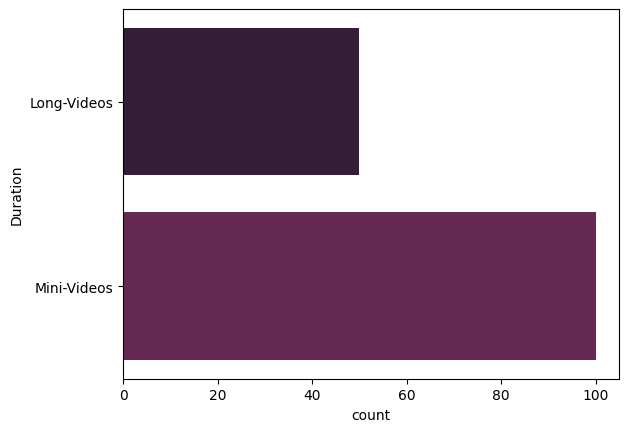

In [53]:
palette = sns.color_palette("rocket")
sns.countplot(y='Duration', data=data, hue = 'Duration', palette=palette, legend=False)
plt.show()